In [45]:
import pyarrow.parquet as pq
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [46]:
df = pd.read_parquet("Skim_10_11.parquet")

In [47]:
df["label"] = 0
df = df[df['weight']>0 ]

In [48]:
print(df)

       weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0    0.000025  1.151401  2.699523   1.979170    1.137842  1.603054  1.725826   
1    0.000025 -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   
2    0.000025  0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
3    0.000025  1.962913 -3.129909   4.803318    1.323140  2.307431 -2.418910   
4    0.000025 -1.630125 -1.711777   1.767290    0.666849 -0.139589 -1.830953   
..        ...       ...       ...        ...         ...       ...       ...   
687  0.784736  0.892076 -0.133293   0.600080    0.421109 -1.847214 -0.196785   
688  0.784736  2.357798  0.196086   8.277598    1.552687  2.074468 -2.216101   
689  0.784736  0.037749  2.375303   0.662115    0.661643  1.665867  2.953054   
690  0.784736  2.519501  1.856302   4.363004    0.697919  1.706206 -0.204428   
691  0.784736 -1.269456  1.293445   1.083464    0.564319  0.837923 -0.183357   

     E_mGG_ph2  pT_mGG_ph2  Electron_E 

In [49]:
df = df[~df.process.str.contains("QCD")]
#df = df[~df.process.str.contains("GluGluHToGG")]
#df = df[~df.process.str.contains("VBFToGG")]
#df = df[~df.process.str.contains("TTWJets")]
#df = df[~df.process.str.contains("TTGG_0Jets_")]
#df = df[~df.process.str.contains("TTGamma")]
#df = df[~df.process.str.contains("WW_Tune")]
#df = df[~df.process.str.contains("THQ_ctc")]
#df = df[~df.process.str.contains("W1Jets")]
#df = df[~df.process.str.contains("W2Jets")]
#df = df[~df.process.str.contains("W3Jets")]



#df.to_csv("dataframe_HHWWgg_withoutDY.csv")

In [50]:
df.loc[df.process.str.contains("HHH"), ['label']] = 1

In [51]:
batch_size = 128


def checkBatches(df):
    N_checks = 1000
    sum_sig = 0.
    N_sig = 0
    sum_back = 0.
    N_back = 0
    for i in range(N_checks):
        rnd_df = df.sample(batch_size)
        sum_sig  += rnd_df[rnd_df['label']==1]['weight'].sum()
        sum_back += rnd_df[rnd_df['label']==0]['weight'].sum()
        N_sig    += rnd_df[rnd_df['label']==1].shape[0]
        N_back   += rnd_df[rnd_df['label']==0].shape[0]
    sum_sig  /= N_checks
    sum_back /= N_checks
    N_sig    /= N_checks
    N_back   /= N_checks

    print (f'On average, per batch the total learning weight is\n\t... signal     : {sum_sig:12.6f} [{N_sig} events] \n\t... background : {sum_back:12.6f} [{N_back} events]')



In [52]:
checkBatches(df)

On average, per batch the total learning weight is
	... signal     :     0.000909 [35.63 events] 
	... background :   116.367597 [92.37 events]


In [53]:
print(df)

       weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0    0.000025  1.151401  2.699523   1.979170    1.137842  1.603054  1.725826   
1    0.000025 -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   
2    0.000025  0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
3    0.000025  1.962913 -3.129909   4.803318    1.323140  2.307431 -2.418910   
4    0.000025 -1.630125 -1.711777   1.767290    0.666849 -0.139589 -1.830953   
..        ...       ...       ...        ...         ...       ...       ...   
687  0.784736  0.892076 -0.133293   0.600080    0.421109 -1.847214 -0.196785   
688  0.784736  2.357798  0.196086   8.277598    1.552687  2.074468 -2.216101   
689  0.784736  0.037749  2.375303   0.662115    0.661643  1.665867  2.953054   
690  0.784736  2.519501  1.856302   4.363004    0.697919  1.706206 -0.204428   
691  0.784736 -1.269456  1.293445   1.083464    0.564319  0.837923 -0.183357   

     E_mGG_ph2  pT_mGG_ph2  Electron_E 

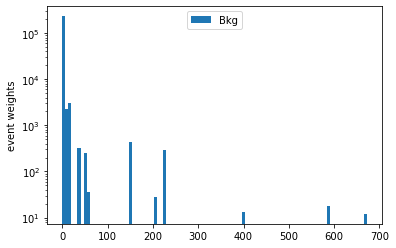

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
plt.hist(df.loc[df['label']==0,'weight'],bins=100,label='Bkg')
plt.yscale('log') 
plt.ylabel('event weights')
#plt.ylabel('')
#plt.title('dnn_score')
plt.legend(loc='upper center')
fig.savefig("event_weights_B.pdf", dpi = 300)



In [55]:
HHsum_weighted = df[df['label']==1]['weight'].sum()
print(HHsum_weighted)
HHsum_unweighted = 614702.0
bckgsum_weighted = df[df['label']==0]['weight'].sum() 
print(bckgsum_weighted)
classweight_Target = HHsum_unweighted

lumi = 3000000

xsec_HH_2G2Qlnu = 0.00001563556176
HH_2G2Qlnu_sum_weighted = df[df['label']==1]['weight'].sum()

xsec_HH_2G2l2nu = 0.0000037234
xsec_HH_2G2Tau = 0.00000104441

xsec_GGH = 0.114798
GGH_sum_weighted = df[df.process.str.contains("GluGluHToGG")]['weight'].sum()
print(GGH_sum_weighted)

xsec_VBF = 0.00951216
VBF_sum_weighted = df[df.process.str.contains("VBF")]['weight'].sum()

xsec_ttH = 0.001393764
ttH_sum_weighted = df[df.process.str.contains("ttH")]['weight'].sum()

xsec_VH = 0.00544326
VH_sum_weighted = df[df.process.str.contains("VH")]['weight'].sum()

xsec_TTW = 0.2253
TTW_sum_weighted = df[df.process.str.contains("TTW")]['weight'].sum()

xsec_TTGG_0Jets = 0.01864
TTGG_0Jets_sum_weighted = df[df.process.str.contains("TTGG_0Jets")]['weight'].sum()

xsec_TT_Tune = 864.4 
TT_Tune_sum_weighted = df[df.process.str.contains("TT_Tune")]['weight'].sum()

xsec_TTGamma_Dilept = 0.6231
TTGamma_Dilept_sum_weighted = df[df.process.str.contains("TTGamma_Dilept")]['weight'].sum()

xsec_TTGamma_Hadronic = 0.799
TTGamma_Hadronic_sum_weighted = df[df.process.str.contains("TTGamma_Hadronic")]['weight'].sum()

xsec_TTGamma_SingleLeptFromT = 0.7709 
TTGamma_SingleLeptFromT_sum_weighted = df[df.process.str.contains("SingleLeptFromT")]['weight'].sum()

xsec_TTGamma_SingleLeptFromTbar = 0.769
TTGamma_SingleLeptFromTbar_sum_weighted = df[df.process.str.contains("SingleLeptFromTbar")]['weight'].sum()

xsec_W1Jets = 10370 
W1Jets_sum_weighted = df[df.process.str.contains("W1Jets")]['weight'].sum()

xsec_W2Jets = 2965
W2Jets_sum_weighted = df[df.process.str.contains("W2Jets")]['weight'].sum()

xsec_W3Jets = 1268
W3Jets_sum_weighted = df[df.process.str.contains("W3Jets")]['weight'].sum()

xsec_GJet40toInf = 998.1 
GJet40toInf_sum_weighted = df[df.process.str.contains("GJet_Pt-40toInf")]['weight'].sum()

xsec_GJet20to40 = 260.85
GJet20to40_sum_weighted = df[df.process.str.contains("GJet_Pt-20to40")]['weight'].sum()

xsec_GJet20toInf = 3901 
GJet20toInf_sum_weighted = df[df.process.str.contains("GJet_Pt-20toInf")]['weight'].sum()

xsec_DiPhoton80toInf = 98.67
DiPhoton80toInf_sum_weighted = df[df.process.str.contains("DiPhotonJetsBox_MGG-80toInf")]['weight'].sum()

xsec_DiPhoton40to80 = 332.804
DiPhoton40to80_sum_weighted = df[df.process.str.contains("DiPhotonJetsBox_MGG-40to80")]['weight'].sum()

xsec_WGG = 1.884
WGG_sum_weighted = df[df.process.str.contains("WGGJets_TuneCP5")]['weight'].sum()

xsec_WGJJ = 6.032
WGJJ_sum_weighted = df[df.process.str.contains("WGJJToLNu")]['weight'].sum()

xsec_ZGTo2LG = 145.2
ZGTo2LG_sum_weighted = df[df.process.str.contains("ZGTo2LG")]['weight'].sum()

xsec_WW = 70.44
WW_sum_weighted = df[df.process.str.contains("WW_Tune")]['weight'].sum()

xsec_THQ = 0.000205428
THQ_sum_weighted = df[df.process.str.contains("THQ_ctcvcp_")]['weight'].sum()

xsec_DY = 5711
DY_sum_weighted = df[df.process.str.contains("DYJets")]['weight'].sum()


print (f"Sum of learning weight for signal     = {df[df['label']==1]['weight'].sum():15.5f}")
print (f"Sum of learning weight for background = {df[df['label']==0]['weight'].sum():15.5f}")

# We divide by their sum, and multiply by the number of events
#   First part is so that the sum of weights of the signal is now == to the background ones
#   The second part is because if the weights are super small, the loss will be small
#       In practice the magnitude does not matter, only relative difference, but it is easier
#       to check the learning when the loss variations are not far in the decimals
#       -> like that the average unit weight is 1

df.loc[df['label']==1, 'scale'] = lumi * xsec_HH_2G2Qlnu / HH_2G2Qlnu_sum_weighted

df.loc[df.process.str.contains("GluGluHToGG"), 'scale'] = lumi * xsec_GGH/ GGH_sum_weighted
df.loc[df.process.str.contains("VBF"), 'scale'] = lumi * xsec_VBF/ VBF_sum_weighted
df.loc[df.process.str.contains("ttH"), 'scale'] = lumi * xsec_ttH/ ttH_sum_weighted
df.loc[df.process.str.contains("VH"), 'scale'] = lumi * xsec_VH/ VH_sum_weighted
df.loc[df.process.str.contains("TTW"), 'scale'] = lumi * xsec_TTW/ TTW_sum_weighted
df.loc[df.process.str.contains("TTGG_0Jets"), 'scale'] = lumi * xsec_TTGG_0Jets/ TTGG_0Jets_sum_weighted
df.loc[df.process.str.contains("TT_Tune"), 'scale'] = lumi * xsec_TT_Tune/ TT_Tune_sum_weighted
df.loc[df.process.str.contains("TTGamma_Dilept"), 'scale'] = lumi * xsec_TTGamma_Dilept/ TTGamma_Dilept_sum_weighted
df.loc[df.process.str.contains("TTGamma_Hadronic"), 'scale'] = lumi * xsec_TTGamma_Hadronic/ TTGamma_Hadronic_sum_weighted
df.loc[df.process.str.contains("TTGamma_SingleLeptFromT"), 'scale'] = lumi * xsec_TTGamma_SingleLeptFromT/ TTGamma_SingleLeptFromT_sum_weighted
df.loc[df.process.str.contains("TTGamma_SingleLeptFromTbar"), 'scale'] = lumi * xsec_TTGamma_SingleLeptFromTbar/ TTGamma_SingleLeptFromTbar_sum_weighted
df.loc[df.process.str.contains("W1Jets"), 'scale'] = lumi * xsec_W1Jets/ W1Jets_sum_weighted
df.loc[df.process.str.contains("W2Jets"), 'scale'] = lumi * xsec_W2Jets/ W2Jets_sum_weighted
df.loc[df.process.str.contains("W3Jets"), 'scale'] = lumi * xsec_W3Jets/ W3Jets_sum_weighted
df.loc[df.process.str.contains("GJet_Pt-40toInf"), 'scale'] = lumi * xsec_GJet40toInf/ GJet20to40_sum_weighted
df.loc[df.process.str.contains("GJet_Pt-20to40"), 'scale'] = lumi * xsec_GJet20to40/ GJet20to40_sum_weighted
df.loc[df.process.str.contains("GJet_Pt-20toInf"), 'scale'] = lumi * xsec_GJet20toInf/ GJet20toInf_sum_weighted
df.loc[df.process.str.contains("DiPhotonJetsBox_MGG-80toInf"), 'scale'] = lumi * xsec_DiPhoton80toInf/ DiPhoton80toInf_sum_weighted
df.loc[df.process.str.contains("DiPhotonJetsBox_MGG-40to80"), 'scale'] = lumi * xsec_DiPhoton40to80/ DiPhoton40to80_sum_weighted
df.loc[df.process.str.contains("WGGJets_TuneCP5"), 'scale'] = lumi * xsec_WGG/ WGG_sum_weighted
df.loc[df.process.str.contains("WGJJToLNu"), 'scale'] = lumi * xsec_WGJJ/ WGJJ_sum_weighted
df.loc[df.process.str.contains("ZGTo2LG"), 'scale'] = lumi * xsec_ZGTo2LG/ ZGTo2LG_sum_weighted
df.loc[df.process.str.contains("WW_Tune"), 'scale'] = lumi * xsec_WW/ WW_sum_weighted
df.loc[df.process.str.contains("THQ_ctcvcp_"), 'scale'] = lumi * xsec_THQ/ THQ_sum_weighted
df.loc[df.process.str.contains("DYJets"), 'scale'] = lumi * xsec_DY/ DY_sum_weighted


df["trainingweights"] = df.loc[:,'scale']*df.loc[:,'weight']

df.loc[df['label']==1,'trainingweights'] *= df.shape[0]/2 / df[df['label']==1]['trainingweights'].sum() 
df.loc[df['label']==0,'trainingweights'] *= df.shape[0]/2 / df[df['label']==0]['trainingweights'].sum()

print ("After equalization")
#print (f"Sum of learning weight for signal     = {df[df['label']==1]['weight'].sum():15.5f}")
#print (f"Sum of learning weight for background = {df[df['label']==0]['weight'].sum():15.5f}")
print (f"Sum of learning weight for signal     = {df[df['label']==1]['trainingweights'].sum():15.5f}")
print (f"Sum of learning weight for background = {df[df['label']==0]['trainingweights'].sum():15.5f}")

print (f'Average learning weight = {df["trainingweights"].mean()}')

print ('\nNow let us try again with batches')
#checkBatches(df)

2.3459592
289708.8
414.35626
Sum of learning weight for signal     =         2.34596
Sum of learning weight for background =    289708.81250
After equalization
Sum of learning weight for signal     =    165102.00000
Sum of learning weight for background =    165102.00000
Average learning weight = 1.0000000000000004

Now let us try again with batches


/tmp/ipykernel_65951/485258539.py:125: RuntimeWarning: divide by zero encountered in true_divide
  df.loc[df.process.str.contains("WGJJToLNu"), 'scale'] = lumi * xsec_WGJJ/ WGJJ_sum_weighted


In [56]:
batch_size = 128


def checkBatches_X(df):
    N_checks = 1000
    sum_sig = 0.
    N_sig = 0
    sum_back = 0.
    N_back = 0
    for i in range(N_checks):
        rnd_df = df.sample(batch_size)
        sum_sig  += rnd_df[rnd_df['label']==1]['trainingweights'].sum()
        sum_back += rnd_df[rnd_df['label']==0]['trainingweights'].sum()
        N_sig    += rnd_df[rnd_df['label']==1].shape[0]
        N_back   += rnd_df[rnd_df['label']==0].shape[0]
    sum_sig  /= N_checks
    sum_back /= N_checks
    N_sig    /= N_checks
    N_back   /= N_checks

    print (f'On average, per batch the total learning weight is\n\t... signal     : {sum_sig:12.6f} [{N_sig} events] \n\t... background : {sum_back:12.6f} [{N_back} events]')


checkBatches_X(df)

On average, per batch the total learning weight is
	... signal     :    64.034248 [35.673 events] 
	... background :    74.152600 [92.327 events]


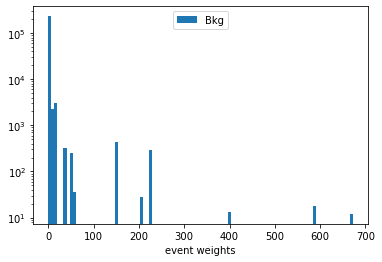

In [57]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(df.loc[df['label']==0,'weight'],bins=100,label='Bkg')
plt.yscale('log') 
plt.xlabel('event weights')
#plt.ylabel('')
#plt.title('dnn_score')
plt.legend(loc='upper center')
fig.savefig("event_weights_A.pdf", dpi = 300)

In [58]:
input_vars=["Eta_ph1",
            "Phi_ph1",
            "E_mGG_ph1",
            "pT_mGG_ph1",
            "Eta_ph2",
            "Phi_ph2",
            "E_mGG_ph2",
            "pT_mGG_ph2",
            "Electron_E",
            "Electron_pT",
            "Electron_Eta",
            "Electron_Phi",
            "Muon_E",
            "Muon_pT",
            "Muon_Eta",
            "Muon_Phi",
            "nJets",
            "E_jet1",
            "pT_jet1",
            "Eta_jet1",
            "Phi_jet1",
            "E_jet2",
            "pT_jet2",
            "Eta_jet2",
            "Phi_jet2",
            "InvM_jet",
            "InvM_jet2",
            "met"]

In [59]:
print(df[input_vars])

      Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  E_mGG_ph2  \
0    1.151401  2.699523   1.979170    1.137842  1.603054  1.725826   2.097534   
1   -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   2.815203   
2    0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   0.430226   
3    1.962913 -3.129909   4.803318    1.323140  2.307431 -2.418910   6.344330   
4   -1.630125 -1.711777   1.767290    0.666849 -0.139589 -1.830953   0.565238   
..        ...       ...        ...         ...       ...       ...        ...   
687  0.892076 -0.133293   0.600080    0.421109 -1.847214 -0.196785   0.569781   
688  2.357798  0.196086   8.277598    1.552687  2.074468 -2.216101   0.728969   
689  0.037749  2.375303   0.662115    0.661643  1.665867  2.953054   1.145351   
690  2.519501  1.856302   4.363004    0.697919  1.706206 -0.204428   1.119852   
691 -1.269456  1.293445   1.083464    0.564319  0.837923 -0.183357   0.297948   

     pT_mGG_ph2  Electron_E

In [60]:
#df_clean = df[input_vars].copy()
#df_clean["label"] = df.loc[:,"label"]
#df_clean.to_csv("dataframe_HHWWgg.csv")
print(df)

       weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0    0.000025  1.151401  2.699523   1.979170    1.137842  1.603054  1.725826   
1    0.000025 -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   
2    0.000025  0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
3    0.000025  1.962913 -3.129909   4.803318    1.323140  2.307431 -2.418910   
4    0.000025 -1.630125 -1.711777   1.767290    0.666849 -0.139589 -1.830953   
..        ...       ...       ...        ...         ...       ...       ...   
687  0.784736  0.892076 -0.133293   0.600080    0.421109 -1.847214 -0.196785   
688  0.784736  2.357798  0.196086   8.277598    1.552687  2.074468 -2.216101   
689  0.784736  0.037749  2.375303   0.662115    0.661643  1.665867  2.953054   
690  0.784736  2.519501  1.856302   4.363004    0.697919  1.706206 -0.204428   
691  0.784736 -1.269456  1.293445   1.083464    0.564319  0.837923 -0.183357   

     E_mGG_ph2  pT_mGG_ph2  Electron_E 

In [61]:
X_train, X_test, y_train, y_test,w_train, w_test = train_test_split(df[input_vars], df.label, df.trainingweights, 
                                                    test_size=0.50, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(df[input_vars], df.label, test_size=0.50, random_state=42)

In [62]:
print(X_train)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
142513 -0.385575  2.709306   0.347005    0.322718 -2.956677 -0.869275   
1618    0.112896  1.427707   0.757874    0.753069  0.172260 -1.941152   
134413 -0.435258  1.577285   0.619663    0.565267  0.529058 -1.379965   
78981  -2.019576 -0.504911   3.107899    0.810632 -1.803933  1.376590   
63197  -1.135346 -1.246751   4.155190    2.420338 -0.433520 -1.021132   
...          ...       ...        ...         ...       ...       ...   
38271  -0.422716  0.049085   0.901017    0.826103 -0.930341 -2.768962   
248399 -0.850894  1.326952   0.794571    0.573952  0.098221 -0.508540   
56695   0.405075  0.528407   0.776439    0.716821  1.559154  1.540974   
78313   1.093404  2.072151   3.586437    2.160837  1.535816  0.860055   
41469   0.879004 -0.960349   1.441053    1.020686 -0.047667 -1.703802   

        E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
142513   1.996195    0.207010  110.396034    60.

In [63]:
print(X_test)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
121027 -0.973898 -2.712737   0.822480    0.543635 -1.601215  1.059530   
227275 -0.192320 -2.211417   1.066592    1.047166 -1.148592 -2.415203   
93748  -1.036928 -1.749705   1.043464    0.657283  0.344046 -2.429103   
16844  -2.125633 -2.266939   3.471472    0.817052 -1.818187  1.513382   
4273   -0.018692  1.210890   0.621947    0.621839 -0.370970 -2.518388   
...          ...       ...        ...         ...       ...       ...   
114717  0.444396 -0.714781   0.707102    0.642599 -0.515669  1.653890   
97494   1.232387 -1.479875   1.214622    0.652847  2.489943  2.140240   
16784   0.396633 -2.403319   0.812599    0.752618 -0.720263 -1.771893   
7189    0.622207  0.090216   2.711518    2.259793 -0.316656  0.224035   
116978 -0.116534 -1.776304   1.186072    1.178064 -0.750116 -0.417573   

        E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
121027   1.180170    0.457368   56.867294    56.

In [64]:
parameters = {
    'epochs'                : 100,
    'lr'                    : 0.001,
    'batch_size'            : 128,
    'n_layers'              : 4,
    'n_neurons'             : 128,
    'hidden_activation'     : 'relu',
    'output_activation'     : 'sigmoid',
}

In [65]:
inputs = keras.Input(shape=(len(input_vars),), name="particles")
x = layers.Dense(parameters['n_neurons'], activation=parameters['hidden_activation'], name=f"dense_1")(inputs)
for i in range(1,parameters['n_layers']):
    x = layers.Dense(parameters['n_neurons'], activation=parameters['hidden_activation'], name=f"dense_{i+1}")(x)
outputs = layers.Dense(1, activation=parameters['output_activation'], name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [66]:
model.compile(
    #optimizer=keras.optimizers.RMSprop(),
    optimizer=keras.optimizers.Adam(lr=parameters['lr']),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.AUC(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()],
)

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 particles (InputLayer)      [(None, 28)]              0         
                                                                 
 dense_1 (Dense)             (None, 128)               3712      
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 predictions (Dense)         (None, 1)                 129       
                                                                 
Total params: 53,377
Trainable params: 53,377
Non-trainable

/home/donertas/.local/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [67]:
print(X_train)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
142513 -0.385575  2.709306   0.347005    0.322718 -2.956677 -0.869275   
1618    0.112896  1.427707   0.757874    0.753069  0.172260 -1.941152   
134413 -0.435258  1.577285   0.619663    0.565267  0.529058 -1.379965   
78981  -2.019576 -0.504911   3.107899    0.810632 -1.803933  1.376590   
63197  -1.135346 -1.246751   4.155190    2.420338 -0.433520 -1.021132   
...          ...       ...        ...         ...       ...       ...   
38271  -0.422716  0.049085   0.901017    0.826103 -0.930341 -2.768962   
248399 -0.850894  1.326952   0.794571    0.573952  0.098221 -0.508540   
56695   0.405075  0.528407   0.776439    0.716821  1.559154  1.540974   
78313   1.093404  2.072151   3.586437    2.160837  1.535816  0.860055   
41469   0.879004 -0.960349   1.441053    1.020686 -0.047667 -1.703802   

        E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
142513   1.996195    0.207010  110.396034    60.

In [68]:
# Callbacks #
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.01, 
                               patience = 100,
                               verbose=1,
                               mode='min')
# Stop the learning when val_loss stops increasing 
# https://keras.io/api/callbacks/early_stopping/

reduce_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                                   factor = 0.1,
                                   min_delta = 0, 
                                   patience = 10,
                                   verbose=2,
                                   mode='min')
# reduce LR if not improvement for some time 
# https://keras.io/api/callbacks/reduce_lr_on_plateau/
from history import LossHistory, PlotHistory
loss_history = LossHistory()

history = model.fit(
    X_train,
    y_train,
    verbose=2,
    batch_size=parameters['batch_size'],
    epochs=parameters['epochs'],
    sample_weight=w_train,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_test, y_test,w_test),
    #validation_data=(X_test, y_test),
    callbacks = [early_stopping, reduce_plateau, loss_history],
)


Epoch 1/100
1290/1290 - 23s - loss: 2.2740 - binary_accuracy: 0.3901 - auc_1: 0.4511 - precision_1: 0.2754 - recall_1: 0.7262 - val_loss: 0.8859 - val_binary_accuracy: 0.5286 - val_auc_1: 0.5369 - val_precision_1: 0.3046 - val_recall_1: 0.5430 - lr: 0.0010 - 23s/epoch - 18ms/step
Epoch 2/100
1290/1290 - 3s - loss: 1.3178 - binary_accuracy: 0.3821 - auc_1: 0.4470 - precision_1: 0.2695 - recall_1: 0.7088 - val_loss: 0.6695 - val_binary_accuracy: 0.3663 - val_auc_1: 0.4551 - val_precision_1: 0.2711 - val_recall_1: 0.7584 - lr: 0.0010 - 3s/epoch - 2ms/step
Epoch 3/100
1290/1290 - 3s - loss: 0.6237 - binary_accuracy: 0.3557 - auc_1: 0.4368 - precision_1: 0.2701 - recall_1: 0.7678 - val_loss: 0.5396 - val_binary_accuracy: 0.4020 - val_auc_1: 0.4725 - val_precision_1: 0.2752 - val_recall_1: 0.7052 - lr: 0.0010 - 3s/epoch - 2ms/step
Epoch 4/100
1290/1290 - 3s - loss: 0.5769 - binary_accuracy: 0.3587 - auc_1: 0.4407 - precision_1: 0.2725 - recall_1: 0.7764 - val_loss: 0.5126 - val_binary_accura

Epoch 31/100
1290/1290 - 3s - loss: 0.4526 - binary_accuracy: 0.3932 - auc_1: 0.4928 - precision_1: 0.2763 - recall_1: 0.7244 - val_loss: 0.4918 - val_binary_accuracy: 0.3568 - val_auc_1: 0.5154 - val_precision_1: 0.2769 - val_recall_1: 0.8160 - lr: 0.0010 - 3s/epoch - 3ms/step
Epoch 32/100
1290/1290 - 3s - loss: 0.4842 - binary_accuracy: 0.4063 - auc_1: 0.5009 - precision_1: 0.2779 - recall_1: 0.7045 - val_loss: 0.5698 - val_binary_accuracy: 0.3393 - val_auc_1: 0.4232 - val_precision_1: 0.2737 - val_recall_1: 0.8333 - lr: 0.0010 - 3s/epoch - 3ms/step
Epoch 33/100
1290/1290 - 3s - loss: 0.4480 - binary_accuracy: 0.3664 - auc_1: 0.4643 - precision_1: 0.2702 - recall_1: 0.7461 - val_loss: 0.5315 - val_binary_accuracy: 0.3360 - val_auc_1: 0.4840 - val_precision_1: 0.2753 - val_recall_1: 0.8517 - lr: 0.0010 - 3s/epoch - 3ms/step
Epoch 34/100
1290/1290 - 3s - loss: 0.4349 - binary_accuracy: 0.3918 - auc_1: 0.5051 - precision_1: 0.2819 - recall_1: 0.7616 - val_loss: 0.4713 - val_binary_accur

Epoch 60/100
1290/1290 - 3s - loss: 0.5065 - binary_accuracy: 0.3110 - auc_1: 0.4959 - precision_1: 0.2780 - recall_1: 0.9192 - val_loss: 0.5327 - val_binary_accuracy: 0.3098 - val_auc_1: 0.4958 - val_precision_1: 0.2767 - val_recall_1: 0.9197 - lr: 1.0000e-06 - 3s/epoch - 3ms/step
Epoch 61/100
1290/1290 - 3s - loss: 0.5065 - binary_accuracy: 0.3109 - auc_1: 0.4959 - precision_1: 0.2780 - recall_1: 0.9191 - val_loss: 0.5327 - val_binary_accuracy: 0.3098 - val_auc_1: 0.4958 - val_precision_1: 0.2767 - val_recall_1: 0.9198 - lr: 1.0000e-06 - 3s/epoch - 3ms/step
Epoch 62/100
1290/1290 - 3s - loss: 0.5065 - binary_accuracy: 0.3110 - auc_1: 0.4959 - precision_1: 0.2780 - recall_1: 0.9192 - val_loss: 0.5326 - val_binary_accuracy: 0.3098 - val_auc_1: 0.4958 - val_precision_1: 0.2767 - val_recall_1: 0.9198 - lr: 1.0000e-06 - 3s/epoch - 3ms/step
Epoch 63/100
1290/1290 - 3s - loss: 0.5064 - binary_accuracy: 0.3110 - auc_1: 0.4959 - precision_1: 0.2780 - recall_1: 0.9192 - val_loss: 0.5326 - val_

Epoch 89/100
1290/1290 - 3s - loss: 0.5061 - binary_accuracy: 0.3110 - auc_1: 0.4959 - precision_1: 0.2780 - recall_1: 0.9193 - val_loss: 0.5325 - val_binary_accuracy: 0.3098 - val_auc_1: 0.4959 - val_precision_1: 0.2768 - val_recall_1: 0.9199 - lr: 1.0000e-09 - 3s/epoch - 3ms/step
Epoch 90/100
1290/1290 - 3s - loss: 0.5061 - binary_accuracy: 0.3110 - auc_1: 0.4959 - precision_1: 0.2780 - recall_1: 0.9193 - val_loss: 0.5325 - val_binary_accuracy: 0.3098 - val_auc_1: 0.4959 - val_precision_1: 0.2768 - val_recall_1: 0.9199 - lr: 1.0000e-09 - 3s/epoch - 3ms/step
Epoch 91/100
1290/1290 - 3s - loss: 0.5061 - binary_accuracy: 0.3110 - auc_1: 0.4959 - precision_1: 0.2780 - recall_1: 0.9193 - val_loss: 0.5325 - val_binary_accuracy: 0.3098 - val_auc_1: 0.4959 - val_precision_1: 0.2768 - val_recall_1: 0.9199 - lr: 1.0000e-09 - 3s/epoch - 3ms/step
Epoch 92/100
1290/1290 - 4s - loss: 0.5061 - binary_accuracy: 0.3110 - auc_1: 0.4959 - precision_1: 0.2780 - recall_1: 0.9193 - val_loss: 0.5325 - val_

Curves saved as Loss_CFNHTUXVHR.png


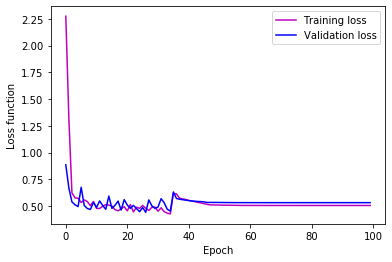

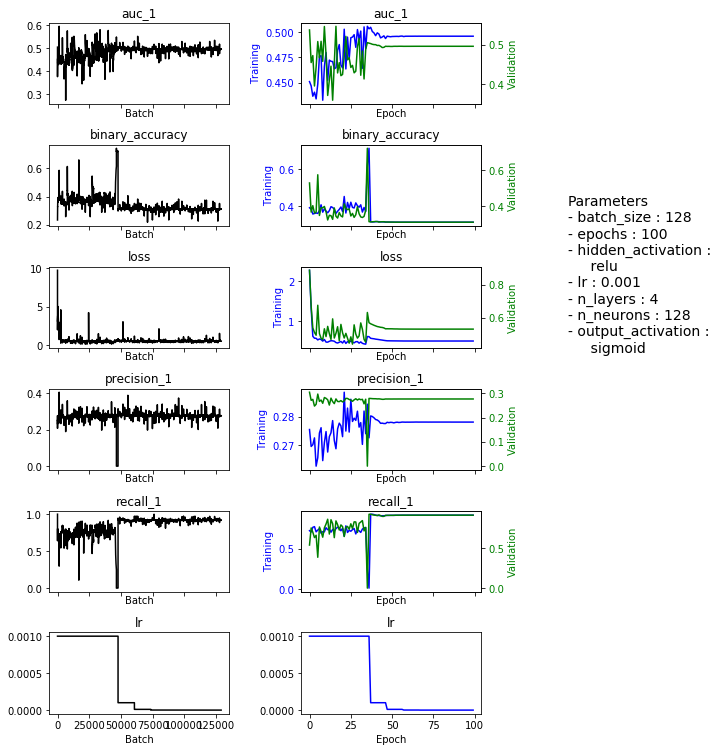

In [69]:
from IPython import embed
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(history.history['loss'],color='m',label='Training loss')
plt.plot(history.history['val_loss'],color='b',label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='upper right')
fig.savefig('training_validation.pdf')

PlotHistory(loss_history,params=parameters)
# Params is a dict of parameters with name and values
# used for plotting


/home/donertas/Desktop/DNN_HHWWGG/roc.py:29: RuntimeWarning: invalid value encountered in true_divide
  z = np.nan_to_num(np.sqrt(2*((s+b)*np.log(1+s/b)-s)))


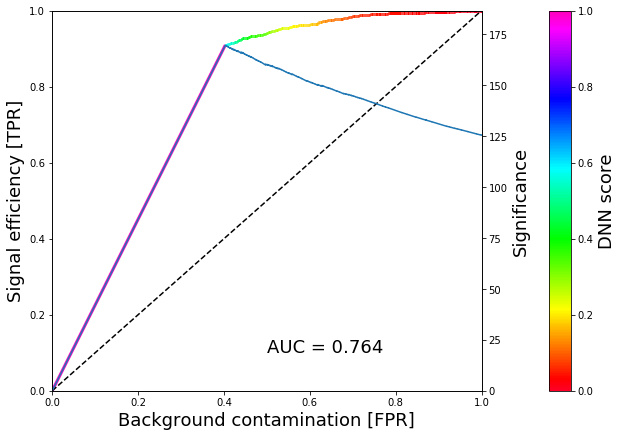

Saved ROC as testflorian.pdf
45875
119227


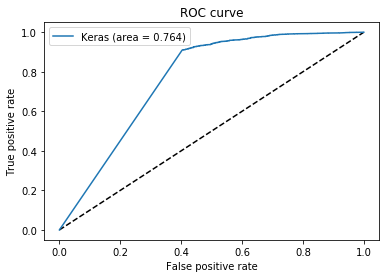

Threshold value is: 0.58197194


In [70]:
prediction = model.predict(X_test)
from sklearn.metrics import roc_curve
import numpy as np
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, prediction,sample_weight=w_test)
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, prediction)

#with open('fpr.npy', 'wb') as f:
 #   np.save(f, np.array(fpr_keras))

from roc import rocAndSig
rocAndSig(y_test,prediction,w_test,'testflorian.pdf')


from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

from IPython import embed
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='XGBoost (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
fig.savefig("ROC_curve.pdf")
plt.show()
optimal_idx = np.argmax(tpr_keras - fpr_keras)
optimal_threshold = thresholds_keras[optimal_idx]
print("Threshold value is:", optimal_threshold)


119227
45875


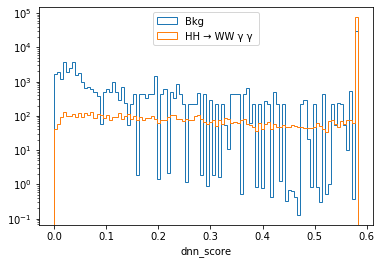

In [71]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(prediction[y_test==0],weights=w_test[y_test==0],histtype=("step"),bins=100,label='Bkg')
plt.hist(prediction[y_test==1],weights=w_test[y_test==1],histtype=("step"),bins=100,label='HH \u2192 WW \u03B3 \u03B3 ')
plt.yscale('log') 
plt.xlabel('dnn_score')
#plt.ylabel('')
#plt.title('dnn_score')
plt.legend(loc='upper center')
fig.savefig("prediction.pdf", dpi = 300)
print(y_test[y_test==0].shape[0] )
print(y_test[y_test==1].shape[0])

In [ ]:
# evaluate the model
scores = model.evaluate(X_test, y_test, sample_weight=w_test, verbose=2)
#scores = model.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
# save model and architecture to single file
model.save("model_dnn_13_12_noQCD")
print("Saved model to disk")